In [1]:
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Prepare Data

In [2]:
df = pd.read_csv('data/adult.data',
                 names=['age', 'workclass', 'fnlwgt',
                        'education', 'education-num', 'marital-status',
                        'occupation', 'relationship', 'race',
                        'gender', 'capital-gain', 'capital-loss',
                        'hours-per-week', 'native-country', 'salary'])

In [3]:
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
df = df[(df['race'].isin(['White', 'Black'])) & 
        (df['gender'].isin(['Male', 'Female']))].reset_index(drop=True)

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df_m = df.copy(deep=True)

In [6]:
features = ['age', 'workclass', 'fnlwgt',
            'education', 'education-num', 'marital-status',
            'occupation', 'relationship', 'race',
            'gender', 'capital-gain', 'capital-loss',
            'hours-per-week', 'native-country']
target = ['salary']
df_X = df_m[features]
df_y = df_m[target]

In [7]:
df_X_display = df[features]
df_y_display = df[target]

In [8]:
# First, encode the input features
feature_encoders = [LabelEncoder() for _ in features]
for idx, feature in tqdm(enumerate(features)):
    feature_encoders[idx].fit(df[feature])

0it [00:00, ?it/s]

In [9]:
for idx, feature in tqdm(enumerate(features)):
    df_X[feature] = feature_encoders[idx].transform(df[feature])

0it [00:00, ?it/s]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,22,7,2494,9,12,4,1,1,1,1,25,0,39,38
1,33,6,2718,9,12,2,4,0,1,1,0,0,12,38
2,21,4,13378,11,8,0,6,1,1,1,0,0,39,38
3,36,4,14570,1,6,2,6,0,0,1,0,0,39,38
4,11,4,18432,9,12,2,10,5,0,0,0,0,39,5


In [11]:
df_y['salary'] = df_y['salary'].apply(lambda x: 0 if x == '<=50K' else 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
df_y.values.reshape(len(df_y), ).shape

(30940,)

In [13]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(df_X, 
                                                    df_y.values.reshape(len(df_y),), 
                                                    test_size=0.2, 
                                                    random_state=24)

In [14]:
# create a train/test split
X_display_train, X_display_test, y_display_train, y_display_test = train_test_split(df_X_display, 
                                                    df_y.values.reshape(len(df_y),), 
                                                    test_size=0.2, 
                                                    random_state=24)

# Train Model

In [15]:
def create_random_forest_model(n_estimators, 
                               max_depth=10,
                               criterion='gini',
                               random_state=42,
                               n_jobs=4):
    return RandomForestClassifier(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  criterion=criterion,
                                  random_state=random_state,
                                  n_jobs=n_jobs)

In [16]:
adult_model = create_random_forest_model(10, max_depth=20)
adult_model.fit(X_train, y_train)
acc = adult_model.score(X_test, y_test)
print(acc)

0.8581124757595345


In [17]:
y_baseline = [1 for _ in range(len(y_test))]
y_test_pred = adult_model.predict(X_test)
y_test_proba = adult_model.predict_proba(X_test)

In [18]:
from sklearn.metrics import recall_score, precision_score, f1_score

precision = precision_score(y_test, y_test_pred)
p_baseline = precision_score(y_test, y_baseline)
recall = recall_score(y_test, y_test_pred)
r_baseline = recall_score(y_test, y_baseline)
f1 = f1_score(y_test, y_test_pred)
f1_baseline = f1_score(y_test, y_baseline)
print(precision)
print(p_baseline)
print(recall)
print(r_baseline)
print(f1)
print(f1_baseline)

0.7417538213998391
0.23901098901098902
0.623394185260311
1.0
0.677443056576047
0.3858093126385809


# Feature Importance

In [19]:
adult_fi = adult_model.feature_importances_ * 100

In [20]:
adult_fi

array([14.73923224,  3.68757446, 11.69965575,  3.68749756, 10.59587796,
        7.0772381 ,  6.32483776, 11.95213777,  0.78988444,  1.79489425,
       13.5162841 ,  4.62914382,  8.13447842,  1.37126338])

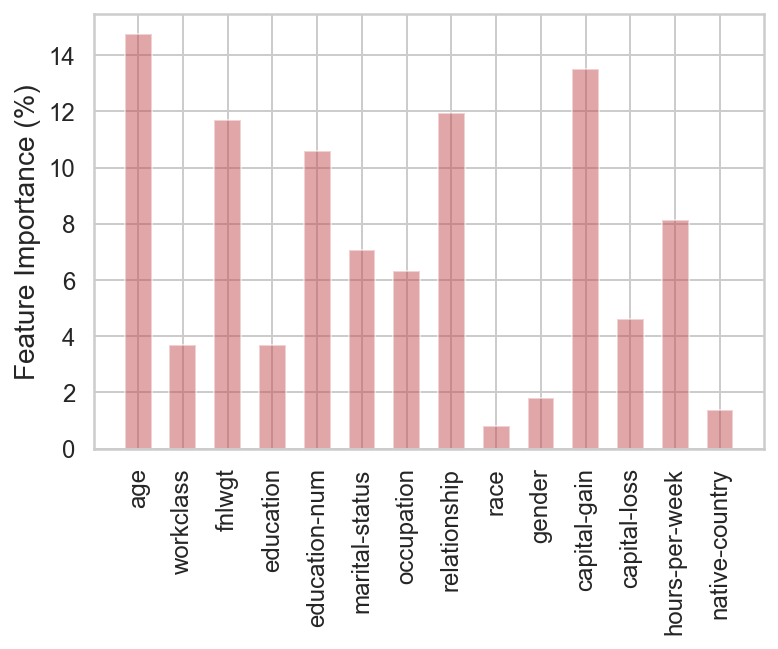

In [21]:
fig, ax = plt.subplots()
index = np.arange(len(features))
bar_width = 0.6
opacity = 0.5
ax.bar(index, adult_fi, bar_width,
       alpha=opacity, color='r',
       label='RF Model')
ax.set_xlabel('')
ax.set_ylabel('Feature Importance (%)')
ax.set_xticks(index)
ax.set_xticklabels(features)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True);
fig.savefig('images/chapter_08_rf_fi.png', dpi=300, bbox_inches='tight');
fig.savefig('images/chapter_08_rf_fi.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Shap Explainer

In [22]:
%%time
explainer = shap.TreeExplainer(adult_model)

CPU times: user 8.9 ms, sys: 4.7 ms, total: 13.6 ms
Wall time: 16 ms


In [23]:
%%time
shap_values = explainer.shap_values(df_X)

CPU times: user 10min, sys: 4.72 s, total: 10min 4s
Wall time: 10min 5s


In [24]:
y = df_y.values.reshape(len(df_y),)

In [25]:
lte50_idx = np.where(y == 0)[0][0]
gt50_idx = np.where(y == 1)[0][1]

In [26]:
shap.initjs()

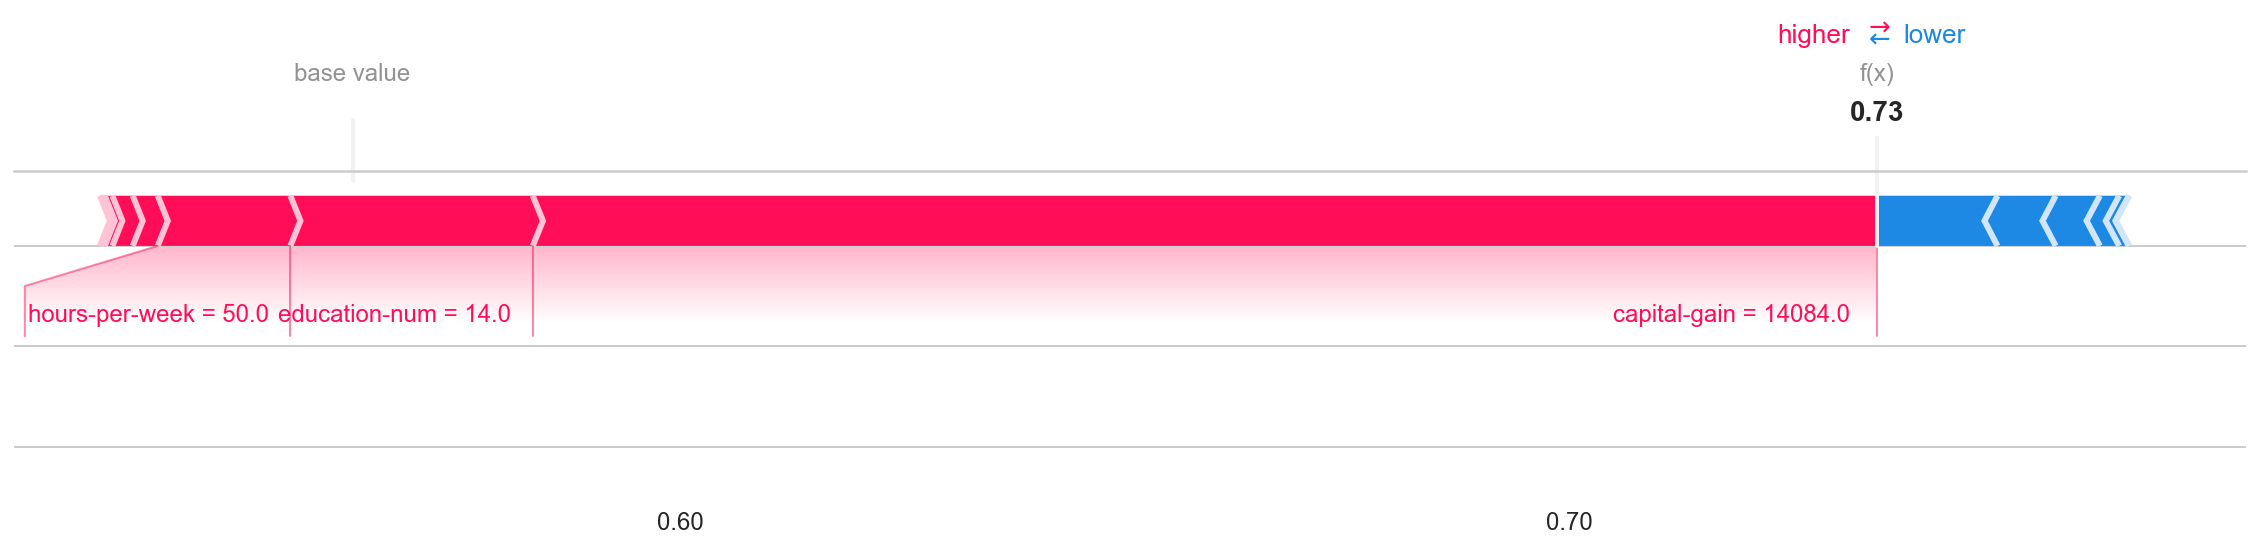

In [28]:
plot = shap.force_plot(explainer.expected_value[1], 
                       shap_values[1][gt50_idx,:], 
                       df_X_display.iloc[gt50_idx,:],
                       link="logit",
                       show=False,
                       matplotlib=True);
plot.savefig('images/chapter_08_shap_gt50k.png', dpi=300, bbox_inches='tight');
plot.savefig('images/chapter_08_shap_gt50k.pdf', format='pdf', dpi=300, bbox_inches='tight');

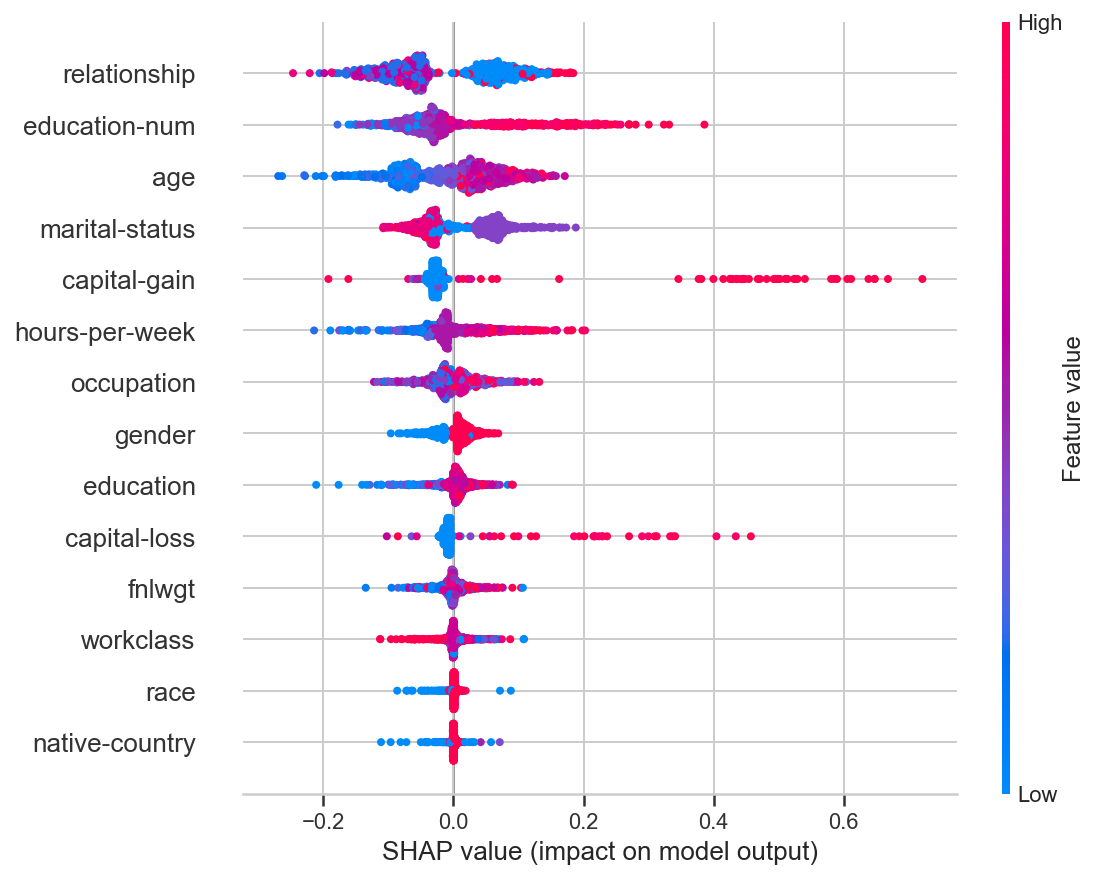

In [29]:
shap.summary_plot(shap_values[1][:1000,:], 
                  df_X.iloc[:1000,:],
                  color='coolwarm',
                  show=False)
plt.savefig('images/chapter_08_shap_summary_plot.png', dpi=300, bbox_inches='tight');
plt.savefig('images/chapter_08_shap_summary_plot.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [30]:
male_indices = df_X[df_X['gender'] == 1].index.values
female_indices = df_X[df_X['gender'] == 0].index.values

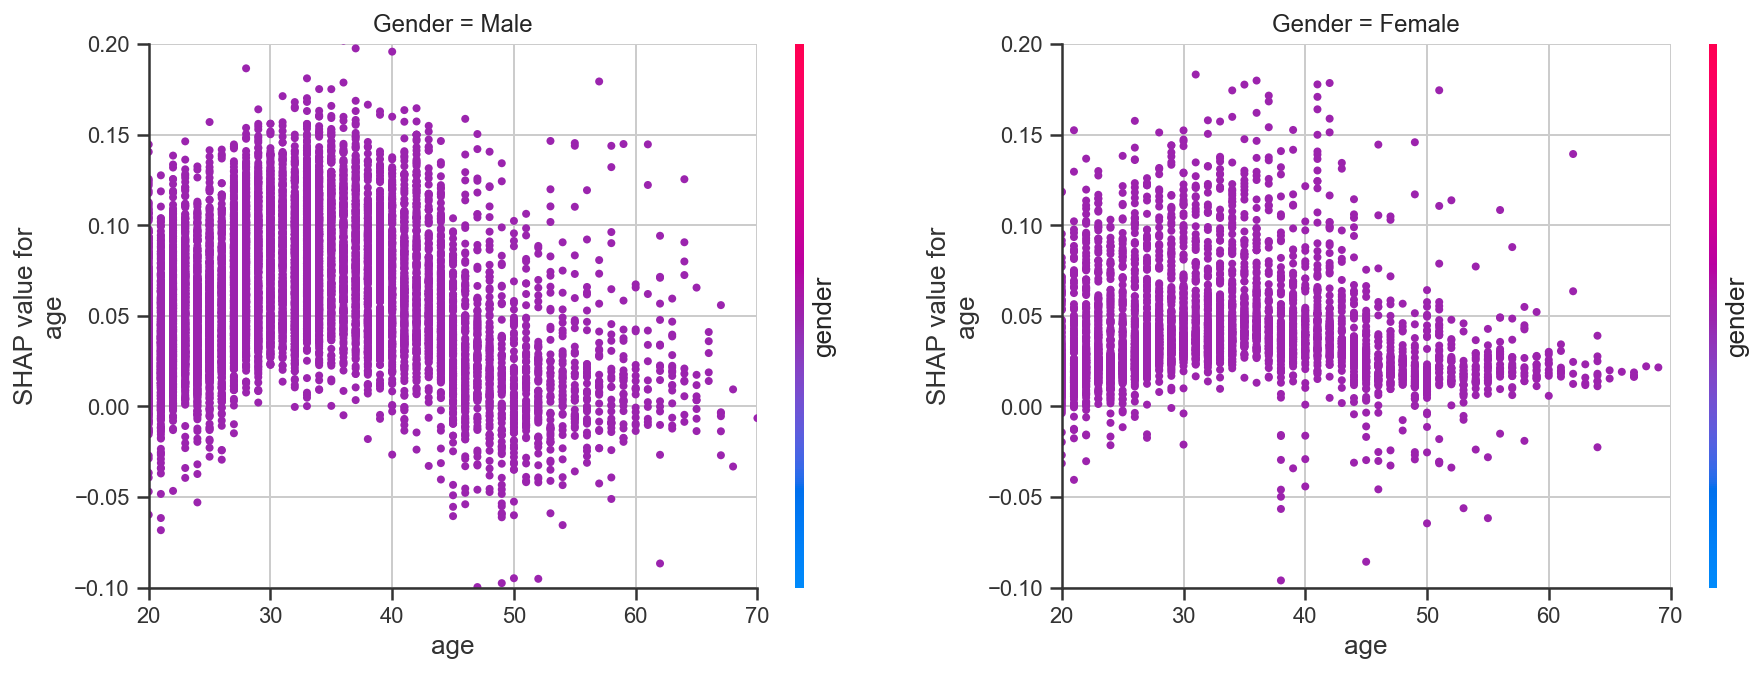

In [31]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('age', 
                     shap_values[1][male_indices, :], 
                     df_X.iloc[male_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('age', 
                     shap_values[1][female_indices, :], 
                     df_X.iloc[female_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_xlim([20, 70])
ax[1].set_xlim([20, 70]);
ax[0].set_ylim([-0.1, 0.2])
ax[1].set_ylim([-0.1, 0.2]);
ax[0].set_title('Gender = Male')
ax[1].set_title('Gender = Female');
f.savefig('images/chapter_08_dep_plot_age_gender.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_age_gender.pdf', format='pdf', dpi=300, bbox_inches='tight');

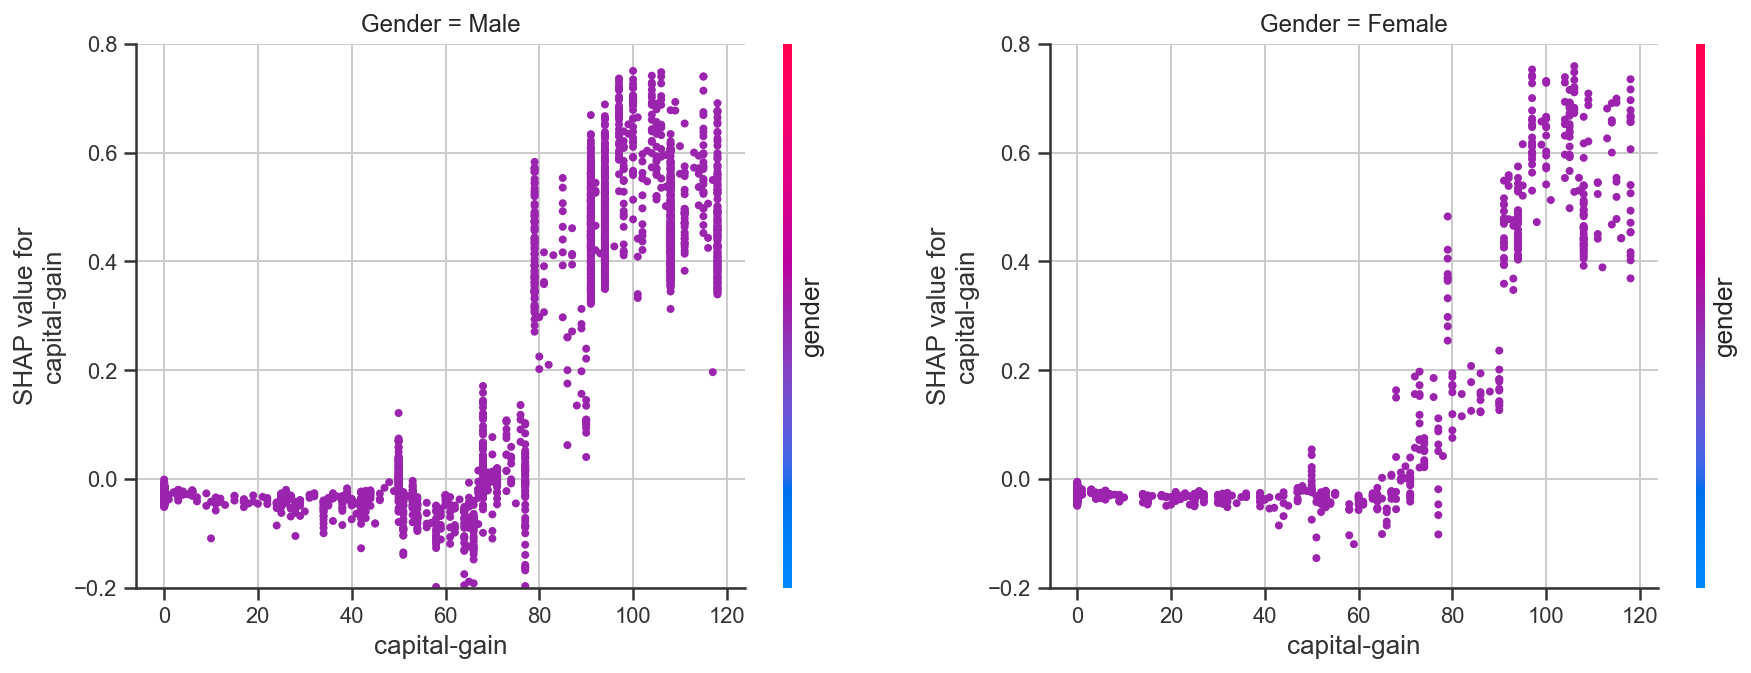

In [32]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('capital-gain', 
                     shap_values[1][male_indices, :], 
                     df_X.iloc[male_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('capital-gain', 
                     shap_values[1][female_indices, :], 
                     df_X.iloc[female_indices, :],
                     interaction_index='gender',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_ylim([-0.2, 0.8])
ax[1].set_ylim([-0.2, 0.8]);
ax[0].set_title('Gender = Male')
ax[1].set_title('Gender = Female');
f.savefig('images/chapter_08_dep_plot_capgain_gender.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_capgain_gender.pdf', format='pdf', dpi=300, bbox_inches='tight');

In [33]:
white_indices = df_X[df_X['race'] == 1].index.values
black_indices = df_X[df_X['race'] == 0].index.values

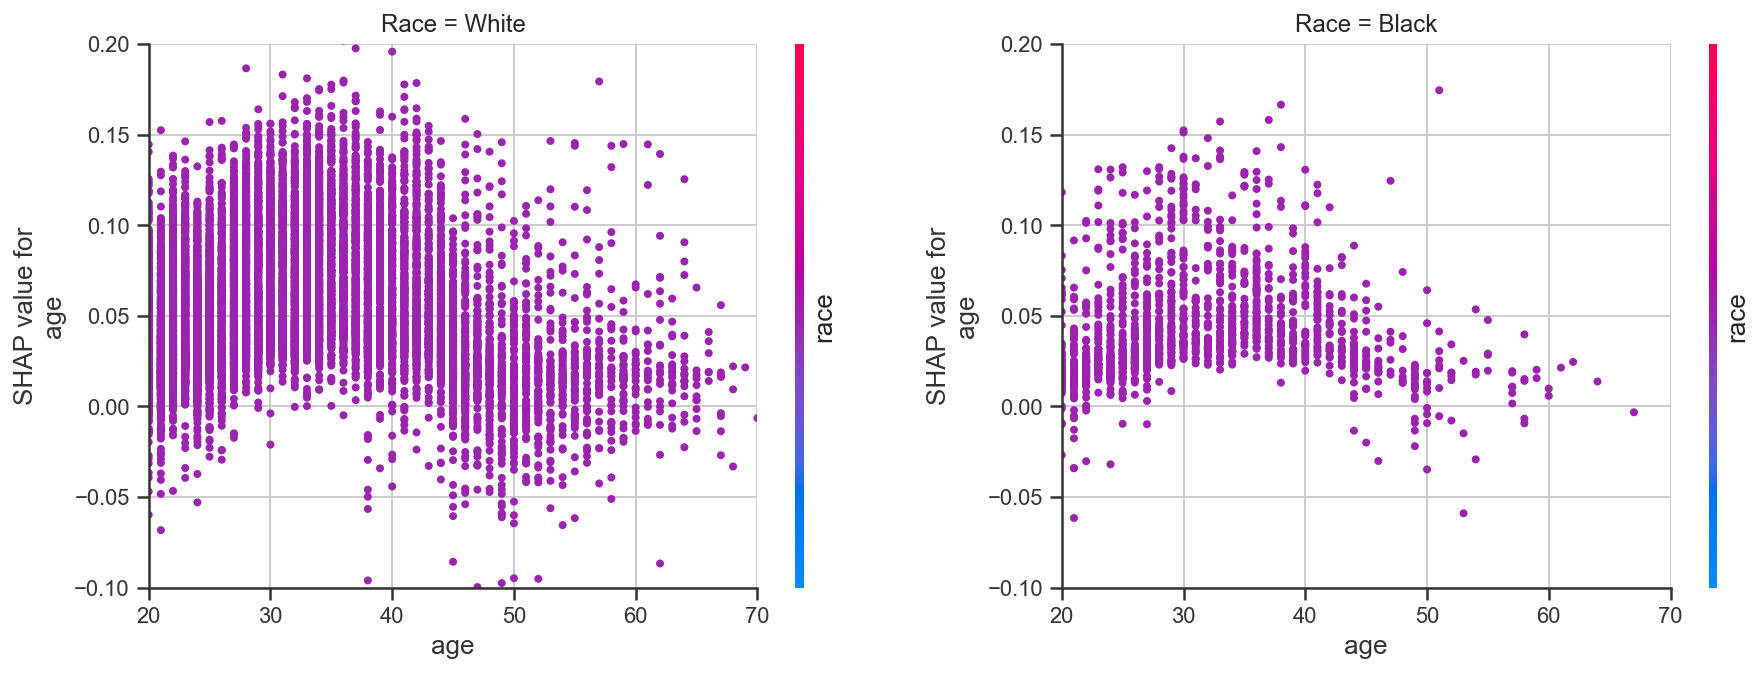

In [34]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('age', 
                     shap_values[1][white_indices, :], 
                     df_X.iloc[white_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('age', 
                     shap_values[1][black_indices, :], 
                     df_X.iloc[black_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_xlim([20, 70])
ax[1].set_xlim([20, 70]);
ax[0].set_ylim([-0.1, 0.2])
ax[1].set_ylim([-0.1, 0.2]);
ax[0].set_title('Race = White')
ax[1].set_title('Race = Black');
f.savefig('images/chapter_08_dep_plot_age_race.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_age_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

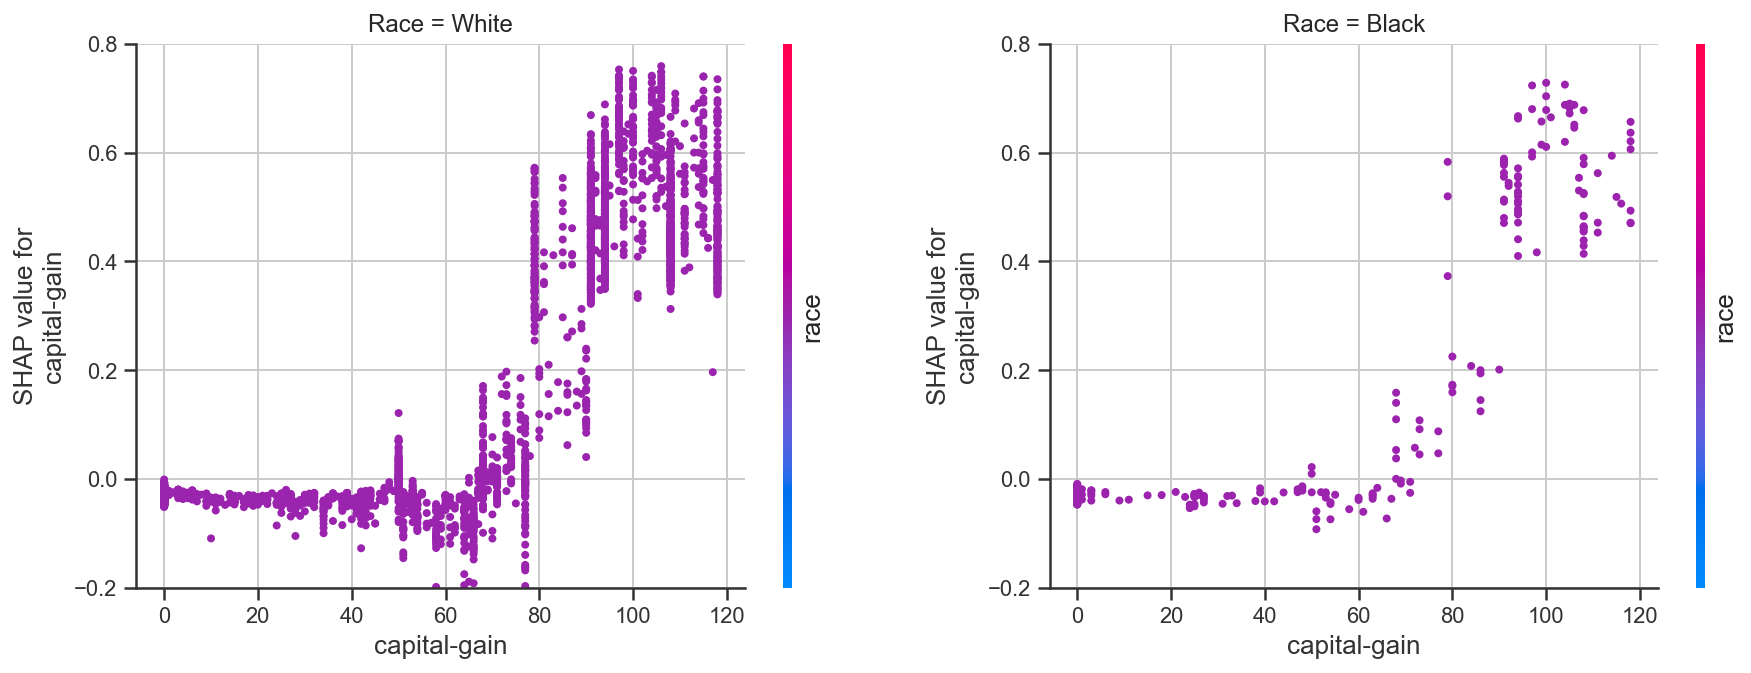

In [35]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
shap.dependence_plot('capital-gain', 
                     shap_values[1][white_indices, :], 
                     df_X.iloc[white_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[0])
shap.dependence_plot('capital-gain', 
                     shap_values[1][black_indices, :], 
                     df_X.iloc[black_indices, :],
                     interaction_index='race',
                     display_features=df_X_display,
                     show=False,
                     ax=ax[1])
ax[0].set_ylim([-0.2, 0.8])
ax[1].set_ylim([-0.2, 0.8]);
ax[0].set_title('Race = White')
ax[1].set_title('Race = Black');
f.savefig('images/chapter_08_dep_plot_capgain_race.png', dpi=300, bbox_inches='tight');
f.savefig('images/chapter_08_dep_plot_capgain_race.pdf', format='pdf', dpi=300, bbox_inches='tight');

# Save Data and Models for Fairness Analysis

In [36]:
import pickle

In [37]:
with open('data/df_X.pkl', 'wb') as f:
    pickle.dump(df_X, f)

In [38]:
with open('data/df_y.pkl', 'wb') as f:
    pickle.dump(df_y, f)

In [39]:
with open('data/df_X_display.pkl', 'wb') as f:
    pickle.dump(df_X_display, f)

In [40]:
with open('data/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [41]:
with open('data/X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [42]:
with open('data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

In [43]:
with open('data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [44]:
with open('models/shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [45]:
with open('models/shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

In [46]:
with open('models/adult_model.pkl', 'wb') as f:
    pickle.dump(adult_model, f)